### Performing parameter studies with PINNs in TorchPhysics
We now consider the wave equation

\begin{align*}
    \partial_t^2 u &= c \, \partial_x^2 u, &&\text{ in } I_x \times I_t, \\
    u &= 0 , &&\text{ on } \partial I_x \times I_t, \\
    (\partial_t u)(\cdot, 0) &= 0 , &&\text{ in } I_x, \\
    u(\cdot, 0) &= \sin(x) , &&\text{ in } I_x,
\end{align*}

with $I_x = [0, 2\pi]$ and $I_t = [0, 5]$. We aim to solve the equation for all $c \in [0.2, 2.5]$.

In this notebook, we provided less guidance to repeat the contents of yesterday.

In [ ]:
# This block is for GPU selection. Please execute.
import pathlib
import os
user = int(str(pathlib.Path().resolve())[22:24])
os.environ["CUDA_VISIBLE_DEVICES"]= str(user % 4)

In [1]:
import torchphysics as tp
import pytorch_lightning as pl
import torch
import math

# Here all parameters are defined:
t_min, t_max = 0.0, 5.0
x_min, x_max = 0.0, 2 * math.pi
c_min, c_max = 0.2, 2.5

# Number of training points 
N_pde = 25000
N_boundary = 5000
N_initial = 5000

# Training parameters
train_iterations = 10000
learning_rate = 8.e-4

/home/nick7/anaconda3/envs/bosch-pde/lib/python3.9/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


In [2]:
### TODO: Implement the spaces
X = tp.spaces.R1('x')
T = tp.spaces.R1('t')
U = tp.spaces.R1('u')
C = tp.spaces.R1('c')

### TODO: Define the domain, time interval and parameter range as torchphysics domains:
I_x = tp.domains.Interval(space=X, lower_bound=x_min, upper_bound=x_max)
I_t = tp.domains.Interval(space=T, lower_bound=t_min, upper_bound=t_max)
I_c = tp.domains.Interval(space=C, lower_bound=c_min, upper_bound=c_max)

### TODO: Create sampler for the PDE condition. Hint: sample from a product domain including x, t and c
pde_sampler = tp.samplers.RandomUniformSampler(domain=I_x * I_t * I_c, n_points=N_pde)

### TODO: Create a random uniform sampler for the Dirichlet boundary condition:
boundary_sampler = tp.samplers.RandomUniformSampler(domain=I_x.boundary * I_t * I_c, n_points=N_boundary)

### TODO: Create a sampler for the two initial conditions:
initial_sampler = tp.samplers.RandomUniformSampler(domain=I_x * I_t.boundary_left * I_c, n_points=N_initial).make_static()

In [3]:
### TODO: Create the neural network for the solution u, depending on the parameter c.
###       The model of u should contain 3 hidden layers with 50 neurons each and should have
###       X*T*C as an input space (order is important for the following cells).
model_u = tp.models.FCN(input_space=X*T*C, output_space=U, hidden = (50,50,50))

In [4]:
### TODO: Define condition for the PDE:
def pde_residual(c, u, t, x):
    return tp.utils.laplacian(u, t) - c * tp.utils.laplacian(u, x)

pde_condition = tp.conditions.PINNCondition(model_u, pde_sampler, pde_residual)

In [5]:
### TODO: Define the Dirichlet boundary condition:
def dirichlet_residual(c, u, t, x):
    return u
dirichlet_condition = tp.conditions.PINNCondition(model_u, boundary_sampler, dirichlet_residual)

In [6]:
### TODO: Define both initial conditions: one that sets the values and one that sets the derivatives, each at t=0.

def initial_residual(c, u, t, x):
    return u - torch.sin(x)
initial_condition = tp.conditions.PINNCondition(model_u, initial_sampler, initial_residual)

def initial_derivative_residual(c, u, t, x):
    return tp.utils.partial(u, t)
initial_derivative_condition = tp.conditions.PINNCondition(model_u, initial_sampler, initial_derivative_residual)

In [ ]:
### The optimizer is already implemented. Just fill in the conditions that should be optimized and you can start the training.

optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=learning_rate)
solver = tp.solver.Solver(train_conditions=[pde_condition, dirichlet_condition, initial_derivative_condition, initial_condition], optimizer_setting=optim)

from pytorch_lightning.callbacks import RichProgressBar
from pytorch_lightning.callbacks.progress.rich_progress import RichProgressBarTheme
trainer = pl.Trainer(devices=1, accelerator="gpu",
                     max_steps=train_iterations,
                     logger=False,
                     benchmark=True,
                     callbacks=[RichProgressBar(theme=RichProgressBarTheme(metrics= "black", metrics_format='.7f'))], # show training process
                     enable_checkpointing=False)

trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 5.4 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
5.4 K     Trainable params
0         Non-trainable params
5.4 K     Total params
0.021     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/nick7/anaconda3/envs/bosch-pde/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/nick7/anaconda3/envs/bosch-pde/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

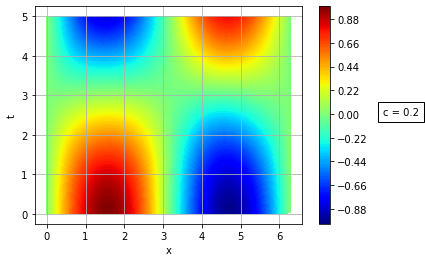

In [11]:
### We can also plot the solution that we learned
plot_domain = tp.domains.Parallelogram(X*T, [x_min, t_min], [x_max, t_min], [x_min, t_max])
plot_sampler = tp.samplers.PlotSampler(plot_domain, 1000, data_for_other_variables={'c': 0.2})
fig = tp.utils.plot(model_u, lambda u: u, plot_sampler, plot_type="contour_surface")

MovieWriter ffmpeg unavailable; using Pillow instead.


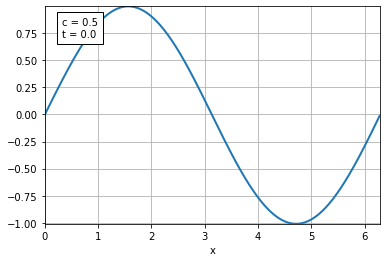

In [9]:
# Or an animation:
anim_sampler = tp.samplers.AnimationSampler(I_x, I_t, 200, n_points=250, data_for_other_variables={'c': 0.5})
fig, anim = tp.utils.animate(model_u, lambda u: u, anim_sampler, ani_speed=40)
anim.save('wave-eq.gif')
# You should be able to see a tab with a folder on the left side of your screen. There you should find the gif and can watch it.